In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import torch
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.benchmark = False

In [3]:
torch.cuda.is_available()

True

In [4]:
outcome='pd_true'

In [5]:
import torch

cuda = torch.device('cuda')     # Default CUDA device
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')  


# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device(cuda)

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(cuda))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: NVIDIA RTX A6000


In [6]:
prefix = './'

In [7]:
all_reports = pd.read_csv(prefix + 'timc_recist_labeled_dataset_id.csv')
all_reports['report_length'] = all_reports.report_text.str.len()
all_reports['date'] = pd.to_datetime(all_reports.date)
all_reports = all_reports.sort_values(by=['obs','dfci_mrn','date'])
all_reports['text'] = all_reports["report_text"]
all_reports['text'] = all_reports.text.str.lower().str.replace("\r|\n", " ")
all_reports['text'] = all_reports.text.str.replace('\s+', ' ')

/tmp/ipykernel_19379/1554159933.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  all_reports['text'] = all_reports.text.str.lower().str.replace("\r|\n", " ")
/tmp/ipykernel_19379/1554159933.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  all_reports['text'] = all_reports.text.str.replace('\s+', ' ')


In [8]:
# remove
all_reports = all_reports.drop_duplicates(subset=['dfci_mrn','text'])

In [9]:
all_reports.shape

(63897, 14)

In [10]:
all_reports['starttime'] = all_reports.groupby('obs').date.transform('first')
all_reports['time'] =  (all_reports['date'] - all_reports['starttime']).dt.days

In [11]:
all_reports.shape

(63897, 16)

In [12]:
all_reports.overall_response_factor.value_counts()

3    20140
0    15935
1    15396
4     9188
2     3238
Name: overall_response_factor, dtype: int64

In [13]:
all_reports.overall_response.value_counts()

SD    20140
BL    15935
PR    15396
PD     9188
CR     3238
Name: overall_response, dtype: int64

In [14]:
all_reports['prcr_true'] = np.where(all_reports.overall_response.isin(['PR','CR']), 1, 0)
all_reports['pd_true'] = np.where(all_reports.overall_response == 'PD', 1, 0)

# baseline scans get coded as -1 for both the PD and PRCR outcomes.
all_reports['outcome'] = np.where(all_reports.overall_response == 'BL', -1, 0)
all_reports['outcome'] = np.where(all_reports[outcome]==1, 1, all_reports['outcome'])
print(all_reports.outcome.value_counts())
print(all_reports.prcr_true.value_counts())
print(all_reports.pd_true.value_counts())
all_reports['is_bl'] = np.where(all_reports.overall_response == 'BL', True, False)

good_obs = all_reports.groupby('obs').is_bl.all().reset_index()
good_obs = good_obs[good_obs.is_bl == False]

all_reports = pd.merge(all_reports, good_obs[['obs']], on='obs')

print(all_reports.outcome.value_counts())
print(all_reports.prcr_true.value_counts())
print(all_reports.pd_true.value_counts())

 0    38774
-1    15935
 1     9188
Name: outcome, dtype: int64
0    45263
1    18634
Name: prcr_true, dtype: int64
0    54709
1     9188
Name: pd_true, dtype: int64
 0    38774
-1    12630
 1     9188
Name: outcome, dtype: int64
0    41958
1    18634
Name: prcr_true, dtype: int64
0    51404
1     9188
Name: pd_true, dtype: int64


In [15]:
training = all_reports[all_reports['split'] == 'train']
validation = all_reports[all_reports['split'] == 'validation']
test = all_reports[all_reports['split'] == 'test']

In [16]:
from torch.utils import data
import torch.nn.functional as F
from transformers import AutoTokenizer

class RecistDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset
        self.max_doc_len = 512
        self.tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
        self.observations = self.data.obs.unique()
        
    def __len__(self):
        # how many observations (pt-trial combos) in the dataset
        return len(self.observations)
    
    def __getitem__(self, index):
        # get data for observation corresponding to index passed
        thisobs = self.observations[index]
        obs = self.data[self.data.obs == thisobs].copy().reset_index(drop=True)
        
        obs['date'] = pd.to_datetime(obs['date'])
        obs = obs.sort_values(by=['date'])

        start_times = torch.tensor(obs.time / 365, dtype=torch.float32)

    
        y_outcome = torch.tensor(obs['outcome'], dtype=torch.float32)

        text = obs.text.tolist()
        
        
        encoded_list = self.tokenizer(text, padding='max_length', max_length=self.max_doc_len, truncation=True)
        input_ids = torch.tensor(encoded_list['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(encoded_list['attention_mask'], dtype=torch.long) 
        
        return input_ids, attention_mask, start_times, y_outcome

    

        

In [17]:
torch.isin(torch.tensor([1,1,4,4,5,5]), torch.unique(torch.tensor([3,2,1])))

tensor([ True,  True, False, False, False, False])

In [18]:
#model 
import math
from transformers import AutoModel
from torch.nn import functional as F
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, GRUCell, Dropout, AdaptiveMaxPool1d
from recistmodels import HTransformer
    
    

###### from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 150):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [19]:
    
class RecistModel(nn.Module):


    def __init__(self):
        super(RecistModel, self).__init__()
        
        self.day_tensor_dim = 768
        self.per_doc_hidden_dim = 256
        
        self.final_hidden_dim = 128
        self.class_output_dim=1
      
        self.note_bert = AutoModel.from_pretrained('medicalai/ClinicalBERT')
            
        self.per_doc_hidden = Linear(self.day_tensor_dim, self.per_doc_hidden_dim)
        
        self.day_transformer = HTransformer(emb=self.per_doc_hidden_dim, heads=4, depth=1)
        
        self.day_position_encoding = PositionalEncoding(self.per_doc_hidden_dim)
        
        self.final_hidden = Linear(self.per_doc_hidden_dim, self.final_hidden_dim)
        
        self.recist_out = Linear(self.final_hidden_dim, self.class_output_dim)

        

        

    def forward(self, input_ids, mask, start_times):

        
        input_ids = input_ids.squeeze(0)
        mask = mask.squeeze(0)
        start_times = start_times.squeeze(0) # now (num_docs,)
        
        # figure out unique start times.
        unique_start_times = torch.unique(start_times)
        
        # restrict to first 20 unique times for training tractability
        unique_start_times = unique_start_times[0:20]
        input_ids = input_ids[torch.isin(start_times, unique_start_times)]
        mask = mask[torch.isin(start_times, unique_start_times)]
        start_times = start_times[torch.isin(start_times, unique_start_times)]
        
        
        main = self.note_bert(input_ids, mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)
              
        main = self.per_doc_hidden(main)

        # batch = sequence_length, embedding
        # permute to get position encoding along temporal dimension


        # add a single batch dimension, then position encode, then remove batch dimension
        main = main.unsqueeze(1)
        main = self.day_position_encoding(main)
        main = main.squeeze(1)
        

        
        # loop over unique start times
        day_tensor_list = []
        for start_time in unique_start_times:
            day_input = main[start_times == start_time]
            
            # batch of 1 axis back
            day_input = day_input.unsqueeze(0)

            day_output = torch.max(day_input, axis=1)[0]

            day_tensor_list.append(day_output)
        day_tensors = torch.cat(day_tensor_list)
        


        # batch axis back for hierarchical transformer
        day_tensors = day_tensors.unsqueeze(0)
        main = self.day_transformer(day_tensors)
        main = self.final_hidden(main)
        main = F.relu(main)
        
        # remove batch axis again
        main = main.squeeze(0)
        main = self.recist_out(main).squeeze(1)
               
        return main

In [20]:
training = training[training['text'].notna()]
validation = validation[validation['text'].notna()]
test = test[test['text'].notna()]
print(training.shape)
print(validation.shape)
print(test.shape)

(49019, 20)
(5477, 20)
(6096, 20)


In [270]:
# train loop
from transformers import get_scheduler, get_linear_schedule_with_warmup
from torch.optim import AdamW, Adam

def train_model(model, num_epochs, optimizer, trainloader, validloader):
    
    
    import torch.optim as optim
   
    num_training_steps = num_epochs * len(trainloader)

    clipping_norm = 5
    noise_multiplier = 0.001
    
    lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = num_epochs * num_training_steps)  # PyTorch scheduler
    
    model.to(device)
    
    for epoch in range(num_epochs):  
        running_train_main_loss = 0.0
        mean_train_main_loss = 0.0

        
        running_val_main_loss = 0.0
        mean_val_main_loss = 0.0

        
        num_train_batches = len(trainloader)
                
        model.train()

        
        for i, batch in enumerate(trainloader, 0):
            ids, mask, s_times, y_true  = [x.to(device) for x in batch]
            

            
            #unique_times = torch.unique(s_times)
            # limit to 20 days for tractability
            unique_times = torch.unique(s_times)[0:20]
            ids = ids[torch.isin(s_times, unique_times)]
            mask = mask[torch.isin(s_times, unique_times)]
            y_true = y_true[torch.isin(s_times, unique_times)]
            s_times = s_times[torch.isin(s_times, unique_times)]
            

            #get rid of batch1 axis from target labels
            y_true = y_true.squeeze(0)


            y_true_list = []
            

 
            for unique_time in unique_times:
                y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])
           
            y_true = torch.stack(y_true_list, dim=0)

            optimizer.zero_grad()
            pred_recist = model(ids, mask, s_times)
            
            y_true_use = y_true[y_true != -1]
            pred_recist_use = pred_recist[y_true != -1]
            
    
            
            if(pred_recist_use.shape[0] > 0):
                loss = F.binary_cross_entropy_with_logits(pred_recist_use, y_true_use)            
                loss.backward()
                
                # Gradient Clipping -from openai o1-preview
                total_norm = 0.0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = math.sqrt(total_norm)
                
                #print(total_norm)
                clip_coef = clipping_norm / (total_norm + 1e-6)
                #print(clip_coef )
                # print(torch.isclose(list(model.parameters())[0].grad.data, torch.tensor(0.), 1e-11))
                if clip_coef < 1.0:
                    for p in model.parameters():
                        p.grad.data.mul_(clip_coef)

                
                #print(noise_multiplier)
                #print(clipping_norm)
                #print(list(model.parameters())[0].grad.data)
                #Add Gaussian Noise
                for p in model.parameters():
                    if p.grad is not None:
                        noise = torch.normal(
                            mean=0.0,
                            std=noise_multiplier * clipping_norm,
                            size=p.grad.data.shape,
                            device=p.grad.data.device
                        )
                        p.grad.data.add_(noise)

                optimizer.step()
                lr_scheduler.step()
            else:
                loss = torch.tensor(0)
            
            running_train_main_loss += loss.data.cpu().numpy()
            mean_train_main_loss = running_train_main_loss / (i+1)

            del ids, mask, s_times, y_true, pred_recist
                
            # print statistics
            print('Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ', main train loss: ' + str(mean_train_main_loss), end='\r', flush=True)


             
        print('')
            
        if validloader is not None:
            # validate
            valid_batches = len(validloader)

            model.eval()

            for j, vbatch in enumerate(validloader, 0):

                ids, mask, s_times, y_true  = [x.to(device) for x in vbatch]
                

                
                #unique_times = torch.unique(s_times)
                # limit to 20 days for tractability
                unique_times = torch.unique(s_times)[0:20]
                ids = ids[torch.isin(s_times, unique_times)]
                mask = mask[torch.isin(s_times, unique_times)]
                y_true = y_true[torch.isin(s_times, unique_times)]
                s_times = s_times[torch.isin(s_times, unique_times)]

                #get rid of batch1 axis from target labels
                y_true = y_true.squeeze(0)

                y_true_list = []

                unique_times = torch.unique(s_times)
                for unique_time in unique_times:
                    y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])

                y_true = torch.stack(y_true_list, dim=0)

                with torch.no_grad():
                    pred_recist = model(ids, mask, s_times)
            
                y_true_use = y_true[y_true != -1]
                pred_recist_use = pred_recist[y_true != -1]

                if(pred_recist_use.shape[0] > 0):
                    loss = F.binary_cross_entropy_with_logits(pred_recist_use, y_true_use)
                else:
                    loss = torch.tensor(0)

                running_val_main_loss += loss.data.cpu().numpy()
                
                del ids, mask, s_times, y_true, pred_recist
            mean_val_main_loss = running_val_main_loss / (j+1)

            print('Epoch: ' + str(epoch+1) + ', main val loss: ' + str(mean_val_main_loss), end='\r', flush=True)
        print('')
    



In [271]:
themodel = RecistModel().to(device)
optimizer = AdamW(themodel.parameters(), lr=1e-6, weight_decay=1e-3)

trainloader = data.DataLoader(RecistDataset(training.reset_index(drop=True)), 
                              batch_size=1, 
                              num_workers=0, 
                              shuffle=True)



/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [272]:
temp = iter(trainloader)
print([x.shape for x in next(temp)])

[torch.Size([1, 4, 512]), torch.Size([1, 4, 512]), torch.Size([1, 4]), torch.Size([1, 4])]


In [273]:
validloader = data.DataLoader(RecistDataset(validation.reset_index(drop=True)), batch_size=1, num_workers=2, shuffle=True)

In [274]:
train_model(themodel,5, optimizer, trainloader, validloader)

torch.save(themodel.state_dict(), prefix+'./recist_bert_htransformer_diffpriv_pd.pt')

Epoch: 1, batch: 4595/4595, main train loss: 0.6677157483111268
Epoch: 1, main val loss: 0.6689266203430252
Epoch: 2, batch: 4595/4595, main train loss: 0.6625828318030323
Epoch: 2, main val loss: 0.6643322734297186
Epoch: 3, batch: 4595/4595, main train loss: 0.6571752916093231
Epoch: 3, main val loss: 0.6675183184012987
Epoch: 4, batch: 4595/4595, main train loss: 0.6560602563768787
Epoch: 4, main val loss: 0.6652544409144616
Epoch: 5, batch: 4595/4595, main train loss: 0.6556538390159866
Epoch: 5, main val loss: 0.6606858234474624


In [275]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 44 to 60447
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               5477 non-null   int64         
 1   dfci_mrn                 5477 non-null   int64         
 2   date                     5477 non-null   datetime64[ns]
 3   report_text              5477 non-null   object        
 4   protocol                 5477 non-null   object        
 5   overall_response         5477 non-null   object        
 6   narrative_text           5476 non-null   object        
 7   impression_text          3255 non-null   object        
 8   drop_this_obs            5477 non-null   bool          
 9   split                    5477 non-null   object        
 10  obs                      5477 non-null   int64         
 11  overall_response_factor  5477 non-null   int64         
 12  report_length            5477 no

In [276]:
validation_day_text = validation.copy()
validation_day_text['text'] = validation_day_text.text.astype(str)
validation_day_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 44 to 60447
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               5477 non-null   int64         
 1   dfci_mrn                 5477 non-null   int64         
 2   date                     5477 non-null   datetime64[ns]
 3   report_text              5477 non-null   object        
 4   protocol                 5477 non-null   object        
 5   overall_response         5477 non-null   object        
 6   narrative_text           5476 non-null   object        
 7   impression_text          3255 non-null   object        
 8   drop_this_obs            5477 non-null   bool          
 9   split                    5477 non-null   object        
 10  obs                      5477 non-null   int64         
 11  overall_response_factor  5477 non-null   int64         
 12  report_length            5477 no

In [277]:
validation_day_text = validation_day_text.sort_values(by=['obs','dfci_mrn','time'])

validation_day_text['text'] = validation_day_text.groupby(['obs','dfci_mrn','time'])['text'].transform(lambda x: ' '.join(x))
validation_day_text = validation_day_text.groupby(['obs','dfci_mrn','time']).first().reset_index()
validation_day_text['timepoint_id'] = validation_day_text.groupby(['obs']).cumcount()
validation_day_text = validation_day_text[validation_day_text.timepoint_id < 20]
output = validation_day_text.reset_index(drop=True)
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2461 entries, 0 to 2460
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   obs                      2461 non-null   int64         
 1   dfci_mrn                 2461 non-null   int64         
 2   time                     2461 non-null   int64         
 3   Unnamed: 0               2461 non-null   int64         
 4   date                     2461 non-null   datetime64[ns]
 5   report_text              2461 non-null   object        
 6   protocol                 2461 non-null   object        
 7   overall_response         2461 non-null   object        
 8   narrative_text           2461 non-null   object        
 9   impression_text          1809 non-null   object        
 10  drop_this_obs            2461 non-null   bool          
 11  split                    2461 non-null   object        
 12  overall_response_factor  2461 non-

In [278]:
validation_day_text.pd_true.value_counts()

0    2036
1     425
Name: pd_true, dtype: int64

In [279]:
validation_day_text.outcome.value_counts()

 0    1550
-1     486
 1     425
Name: outcome, dtype: int64

In [280]:
all_reports.outcome.value_counts()

 0    38774
-1    12630
 1     9188
Name: outcome, dtype: int64

In [281]:
# write out actual validation dataset
themodel = RecistModel()
themodel.load_state_dict(torch.load(prefix+'./recist_bert_htransformer_diffpriv_pd.pt'))
themodel.to(device)

no_shuffle_valid_dataset = data.DataLoader(RecistDataset(validation.sort_values(by=['obs','time'])), batch_size=1, shuffle=False, num_workers=0)

dflist = []
for ids, mask, s_times, y_true in no_shuffle_valid_dataset:
    thisframe = pd.DataFrame()
    
    #unique_times = torch.unique(s_times)
    # limit to 20 days for tractability
    unique_times = torch.unique(s_times)[0:20]
    ids = ids[torch.isin(s_times, unique_times)]
    mask = mask[torch.isin(s_times, unique_times)]
    y_true = y_true[torch.isin(s_times, unique_times)]
    s_times = s_times[torch.isin(s_times, unique_times)]

    #get rid of batch1 axis from target labels
    y_true = y_true.squeeze(0)

    y_true_list = []

    unique_times = torch.unique(s_times)
    for unique_time in unique_times:
        y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])

    y_true = torch.stack(y_true_list, dim=0)
    
    with torch.no_grad():
        y_pred = themodel(ids.to(device), mask.to(device), s_times.to(device))
        
    thisframe = pd.DataFrame(y_pred.cpu().detach().numpy(), columns=['pd_pred'])
  
    dflist.append(thisframe)
    
resultframe = pd.concat(dflist, axis=0)
resultframe = resultframe.reset_index(drop=True)
    

/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [282]:
# only first 20 timepoints per patient
print(output.shape)
print(resultframe.shape)


valid_output = pd.concat([output, resultframe], axis=1)
valid_output = valid_output.sort_values(by=['obs','dfci_mrn', 'date']).reset_index(drop=True)

(2461, 21)
(2461, 1)


In [283]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2461 entries, 0 to 2460
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   obs                      2461 non-null   int64         
 1   dfci_mrn                 2461 non-null   int64         
 2   time                     2461 non-null   int64         
 3   Unnamed: 0               2461 non-null   int64         
 4   date                     2461 non-null   datetime64[ns]
 5   report_text              2461 non-null   object        
 6   protocol                 2461 non-null   object        
 7   overall_response         2461 non-null   object        
 8   narrative_text           2461 non-null   object        
 9   impression_text          1809 non-null   object        
 10  drop_this_obs            2461 non-null   bool          
 11  split                    2461 non-null   object        
 12  overall_response_factor  2461 non-

In [284]:
valid_output = valid_output.sort_values(by=['obs','dfci_mrn', 'date']).reset_index(drop=True)


#valid_output.to_csv(prefix+'./validation_set_output_pd.csv')

In [285]:
import seaborn as sns
import pandas as pd
import numpy as np
#valid_output = pd.read_csv(prefix+'./validation_set_output_pd.csv')


/tmp/ipykernel_19379/1034618822.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==1').pd_pred)
/tmp/ipykernel_19379/1034618822.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==0').pd_pred)


<Axes: xlabel='pd_pred', ylabel='Density'>

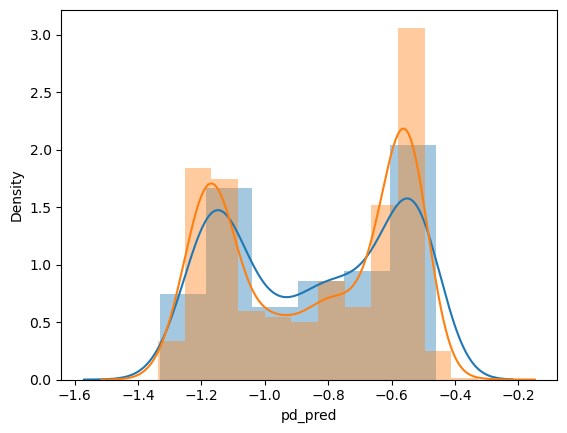

In [286]:
import seaborn as sns
sns.distplot(valid_output.query('pd_true==1').pd_pred)
sns.distplot(valid_output.query('pd_true==0').pd_pred)


/tmp/ipykernel_19379/276717808.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==1').pd_pred)
/tmp/ipykernel_19379/276717808.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==0').pd_pred)


<Axes: xlabel='pd_pred', ylabel='Density'>

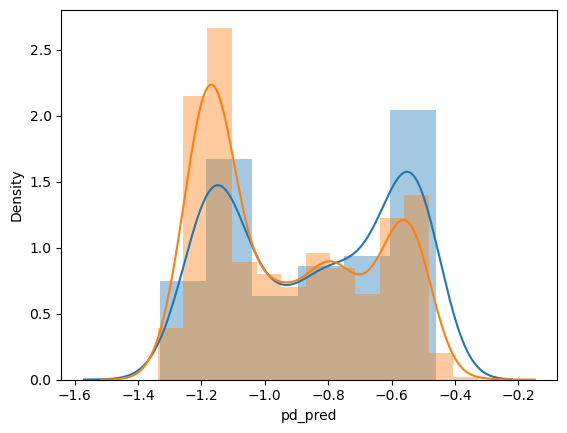

In [287]:
valid_output= valid_output[valid_output.overall_response != 'BL']
sns.distplot(valid_output.query('pd_true==1').pd_pred)
sns.distplot(valid_output.query('pd_true==0').pd_pred)


In [288]:
from sklearn.metrics import roc_auc_score
import matplotlib as plt

%matplotlib inline

In [289]:


# helper functions for performance evaluation


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    import itertools
    import numpy as np

    from sklearn.metrics import confusion_matrix
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

    
    
# now eval model function
# evaluate model auc
def eval_model(predicted, actual, graph=True):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import roc_curve
    
    outcome_counts = np.unique(actual, return_counts=True)[1]
    prob_outcome = outcome_counts[1] / (outcome_counts[0] + outcome_counts[1])

    print("AUC " + str(roc_auc_score(actual, predicted)))

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(actual, predicted)
    roc_auc = auc(fpr, tpr)

    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(actual, predicted)

    print('Outcome probability: ' + str(prob_outcome))

    
    print('Average precision score: {0:0.2f}'.format(
        average_precision))

    # best F1
    precision, recall, thresholds = precision_recall_curve(actual, predicted)

    
    F1 = 2*((precision*recall)/(precision+recall))
    print("Best F1: " + str(max(F1)))

    
    # threshold for best F1
    bestF1_thresh = thresholds[np.argmax(F1)]
    
    if graph==True:
        print('Best F1 threshold: ' + str(bestF1_thresh))
        return bestF1_thresh
    
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic: ' )
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



    import matplotlib.pyplot as plt
    ##from sklearn.utils.fixes import signature



    
    plt.plot(recall, precision, color='b')
    plt.plot([0,1],[prob_outcome,prob_outcome], 'r--')
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))
    plt.show()



    print("Threshold for best F1:")
    print(bestF1_thresh)
    pred_outcome_best_f1_thresh = np.where(predicted >= bestF1_thresh,1,0)
    pred_outcome_05_thresh = np.where(predicted >= 0.5,1,0)
    
    # # predictions
    
    # # confusion matrix
    print("Confusion matrix at best F1 thresh:")
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(actual, pred_outcome_best_f1_thresh)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix, without normalization')
    print("Metrics at best F1 thresh (specificity is recall for negative class):")
    from sklearn.metrics import classification_report
    print(classification_report(actual, pred_outcome_best_f1_thresh, target_names=['No','Yes']))


    print("Confusion matrix at 0.5 thresh:")
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(actual, pred_outcome_05_thresh)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix, without normalization')
    print("Metrics at 0.5 thresh thresh (specificity is recall for negative class):")
    print(classification_report(actual, pred_outcome_05_thresh, target_names=['No','Yes']))





    # # plot threshold vs ppv curve
    plt.plot(thresholds, precision[0:len(precision)-1], color='b')

    plt.xlabel('Threshold probability')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('Threshold vs precision')
    plt.show()

    # histogram
    plt.hist(predicted)
    plt.title("Histogram")
    plt.xlabel("Predicted probability" )
    plt.ylabel("Frequency")
    plt.show()

    return bestF1_thresh
    

In [290]:
valid_output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 1 to 2460
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   obs                      1975 non-null   int64         
 1   dfci_mrn                 1975 non-null   int64         
 2   time                     1975 non-null   int64         
 3   Unnamed: 0               1975 non-null   int64         
 4   date                     1975 non-null   datetime64[ns]
 5   report_text              1975 non-null   object        
 6   protocol                 1975 non-null   object        
 7   overall_response         1975 non-null   object        
 8   narrative_text           1975 non-null   object        
 9   impression_text          1476 non-null   object        
 10  drop_this_obs            1975 non-null   bool          
 11  split                    1975 non-null   object        
 12  overall_response_factor  1975 non-

In [291]:
# AUROC for getting pd scans, excluding baseline scans
roc_auc_score(valid_output.outcome, valid_output.pd_pred)


0.5976227703984819

AUC 0.5976227703984819
Outcome probability: 0.21518987341772153
Average precision score: 0.28
Best F1: 0.3764838892029395


/mnt/d/Partners HealthCare Dropbox/Kenneth Kehl/impression_bert/recist/utils_102023.py:111: RuntimeWarning: invalid value encountered in divide
  F1 = 2*((precision*recall)/(precision+recall))


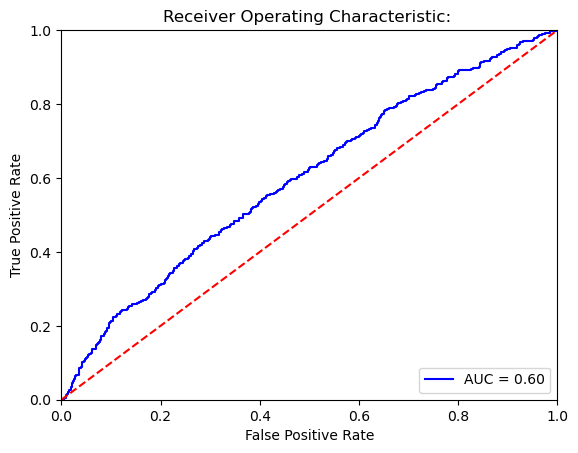

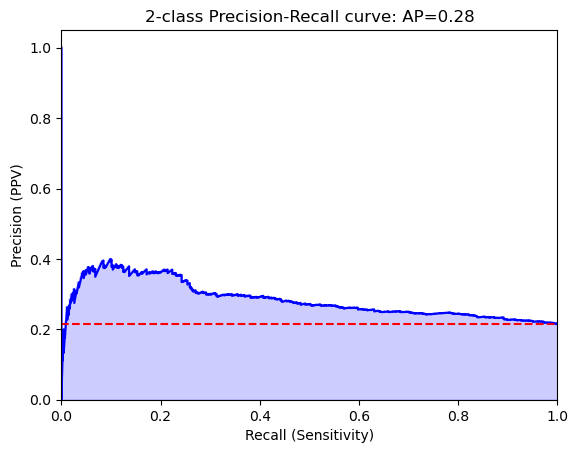

Threshold for best F1:
-0.4536736
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1543    7]
 [ 425    0]]


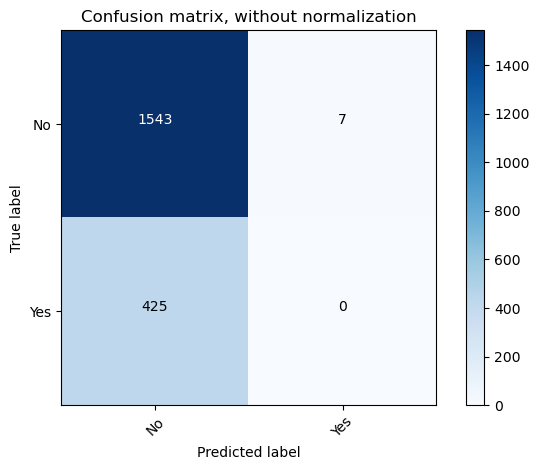

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.78      1.00      0.88      1550
         Yes       0.00      0.00      0.00       425

    accuracy                           0.78      1975
   macro avg       0.39      0.50      0.44      1975
weighted avg       0.62      0.78      0.69      1975

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1550    0]
 [ 425    0]]


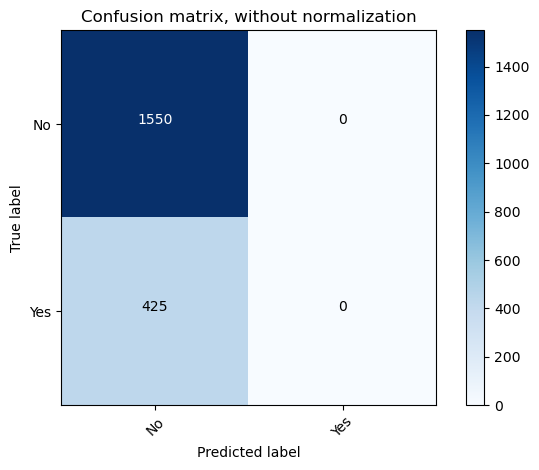

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.78      1.00      0.88      1550
         Yes       0.00      0.00      0.00       425

    accuracy                           0.78      1975
   macro avg       0.39      0.50      0.44      1975
weighted avg       0.62      0.78      0.69      1975



/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

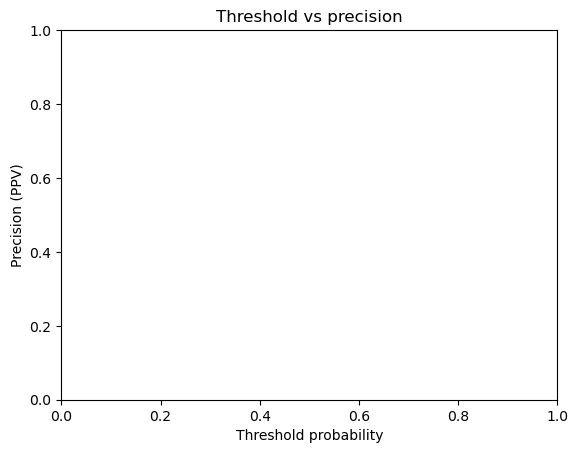

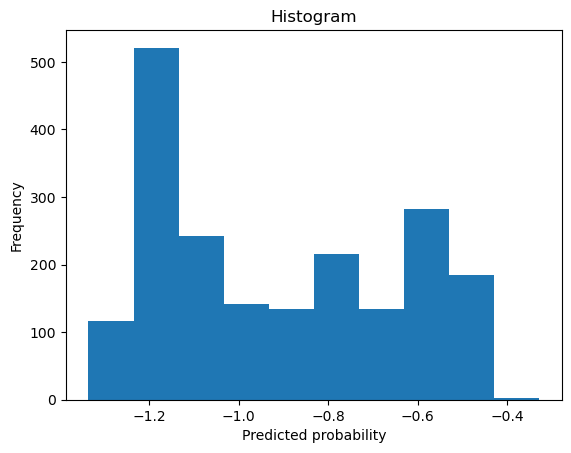

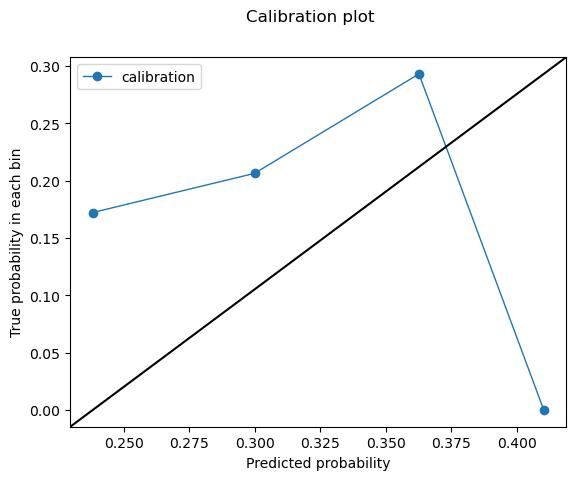

-0.4536736

In [292]:
from utils_102023 import *
eval_model(valid_output.pd_pred, valid_output.outcome, graph=True)